<a href="https://colab.research.google.com/github/marral2/DLMs/blob/main/DL_UNET_Car_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## U-NET

### Installations

In [ ]:
# Library to download an open access file from google drive
!pip install gdown

### Loading used libraries

In [ ]:
import os
import gdown
import zipfile
import PIL
from PIL import Image

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
#
#from jupyterthemes import jtplot
#jtplot.style()

### GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and Dataloader

#### Downloading the data and defining loading paths

In [ ]:
# Google Drive open access ".zip" file link

# Simplified and complete Caravan dataset
# https://drive.google.com/file/d/1t6KsOP6qoH_zFQ2Co6KuSyLwrMf5btAq/view?usp=drive_link
# file_id to identify and download
# file_id = "1t6KsOP6qoH_zFQ2Co6KuSyLwrMf5btAq"

# Simplified and small Caravan dataset
# https://drive.google.com/file/d/1QfXaIZ_4W04u9nUZ1XEvZuHqmWlyvVrq/view?usp=sharing
# file_id to identify and download
# file_id = "1QfXaIZ_4W04u9nUZ1XEvZuHqmWlyvVrq"



# To download the ".zip" file with gdown as a terminal command:
#  small dataset version (still with errors)
#!gdown https://drive.google.com/uc?id=1QfXaIZ_4W04u9nUZ1XEvZuHqmWlyvVrq

# Simple and complete dataset
!gdown https://drive.google.com/uc?id=1t6KsOP6qoH_zFQ2Co6KuSyLwrMf5btAq


Downloading...
From (original): https://drive.google.com/uc?id=1t6KsOP6qoH_zFQ2Co6KuSyLwrMf5btAq
From (redirected): https://drive.google.com/uc?id=1t6KsOP6qoH_zFQ2Co6KuSyLwrMf5btAq&confirm=t&uuid=0cd0039c-4f83-437c-b307-767bab961686
To: /content/Caravana.zip
100% 8.86G/8.86G [01:19<00:00, 112MB/s]


In [ ]:
#file_name = "Caravana_small.zip"
file_name = "Caravana.zip"

# Extract the contents
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
# List the contents of the extracted folder
os.listdir('dataset')

['train_masks', 'test', 'train']

In [ ]:
PATH =  '/content/dataset'
TRAIN_PATH = PATH + "/train" #+"_small"
TRAIN_MASKS_PATH =  PATH + "/train_masks" #+"_small"
TEST_PATH = PATH + "/test" #+"_small"

In [ ]:
TEST_PATH

'/content/dataset/test'

### Visual Example

<img src="https://drive.google.com/uc?id=1Ryt6FLI6eGvB5IslWtGvGMFT0Mu2BzIv" alt="encoder" width="500"/> <img src="https://drive.google.com/uc?id=1aXR1x9aAHlmdwebkpSUmktaeCkVcRBwR" alt="encoder" width="500"/>

#### Dataset

#### transformations

In [ ]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor()] )

In [ ]:
# creating our own Dataset
class Car_Dataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'not the same number of images and masks'
        return len(self.images)

    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)

        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)

            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img

        return img, mask

#### Dataloaders

In [ ]:
full_dataset = Car_Dataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [ ]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

In [ ]:
print(TRAIN_SIZE, VAL_SIZE)

4070 1018


In [ ]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [ ]:
print(len(train_dataset), len(val_dataset))

4070 1018


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


In [ ]:
for i, (x, y) in enumerate(train_loader):
    # X is the image and Y is the mask
    print(i, x.shape, y.shape)
    if i==9: break
# Expected shape of [32, 3, 224, 224]
# 32 images in the batch, 3 color channels, 224 pixels of height (H), and 224 pixels of width (W).

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


#### Let us see the data

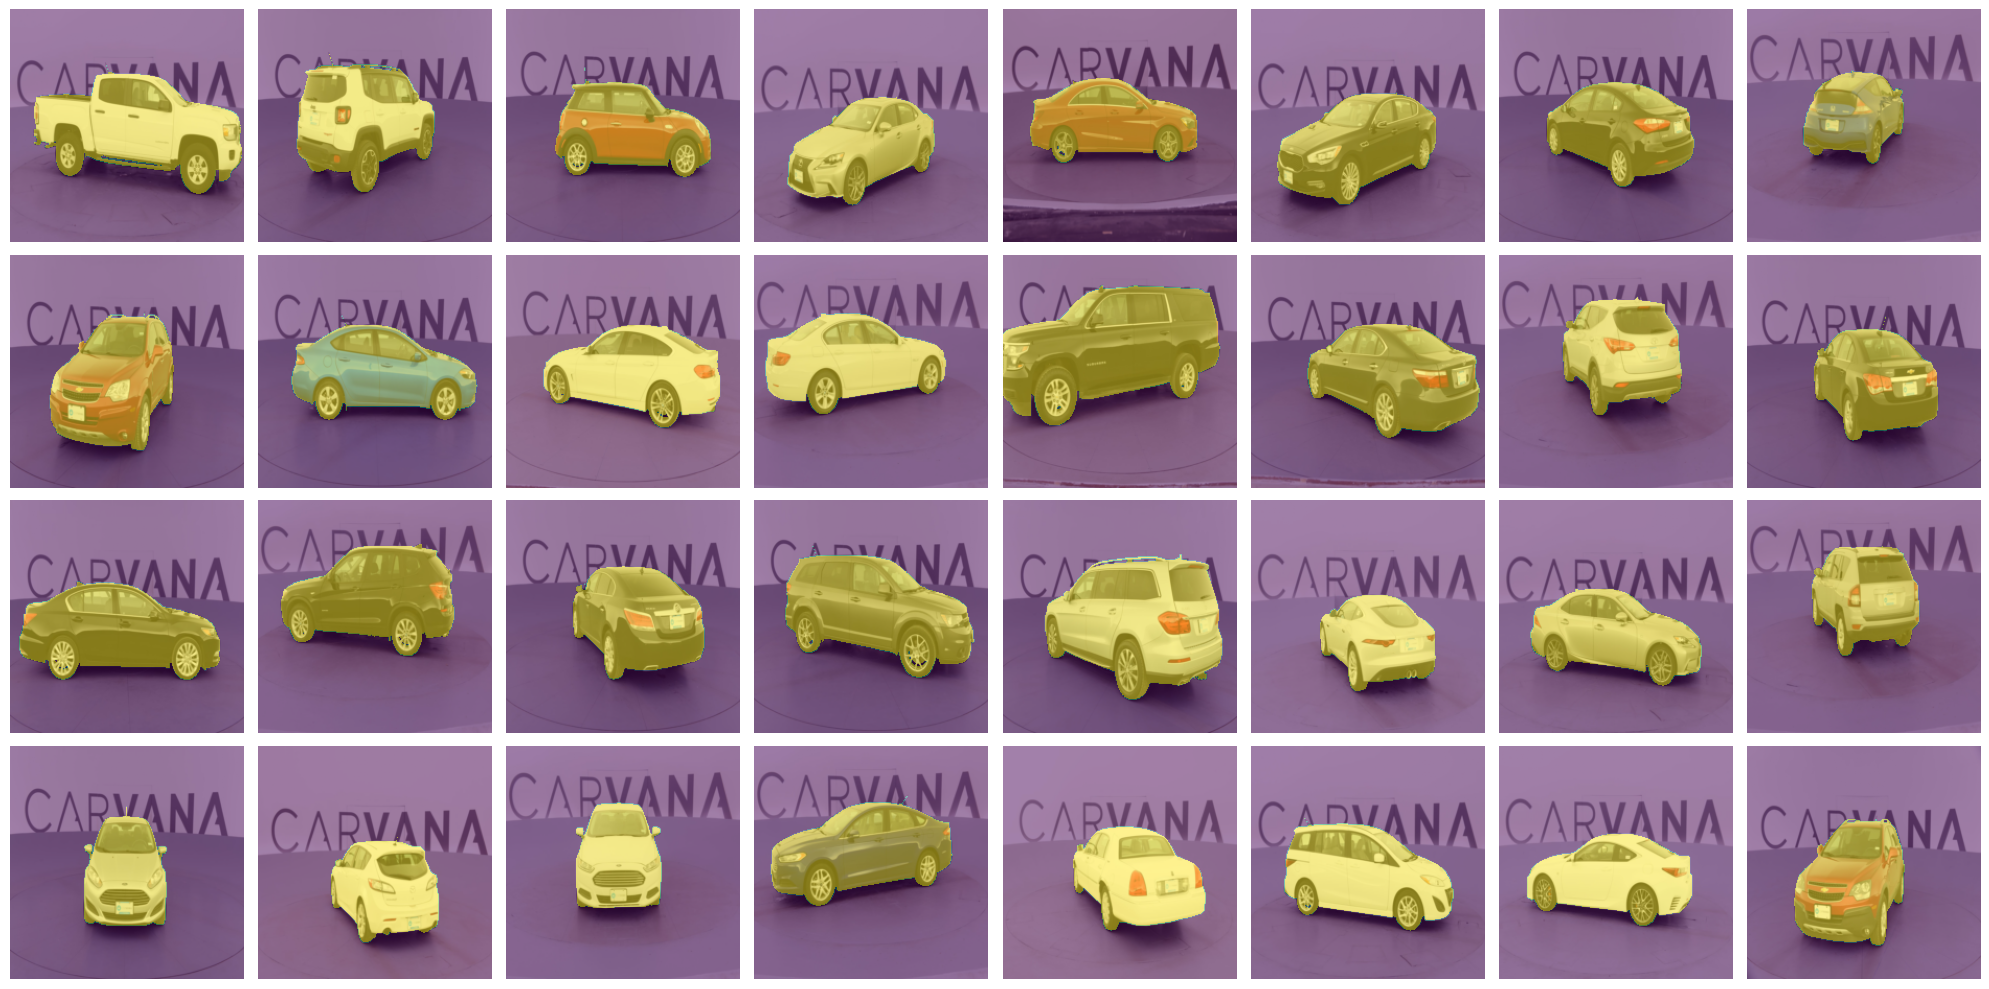

In [ ]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy() # "imgs[i,...]" is indexing one image out of the batch
                                               # ".permute(1,2,0)" rearranges dimensions from [C, H, W] to [H, W, C], the format expected by Matplotlib.
                                               # ".numpy()" converts the tensor back to numpy array to be plottable
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)

        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

### Accuracy

In [ ]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)

        return cost/len(loader), float(correct)/total, dice, iou

In [ ]:
len(train_loader)

128

#### Search for learning rate

In [ ]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

### Train loop

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            if scheduler:
                scheduler.step()

            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f},'
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f},'
                      f'dice: {dice}, iou: {iou}')
                    # Save data
                    #train_acc_history.append(train_acc)
                    #train_cost_history.append(train_cost_every)
        #train_acc = float(train_correct_num)/train_total
        #train_cost_every = float(train_cost_acum)/len(train_loader)
        # return train_acc_history ... etc

### U-NET model

In [ ]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [ ]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),

                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)

class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)

class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)

    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)

class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28

        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14

        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.last_conv(u4)


In [ ]:
def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

In [ ]:
preds = test()

In [ ]:
print(preds.shape)

torch.Size([32, 2, 224, 224])


### Plotting Validation images

In [ ]:
# define the model and look for learning rate
torch.manual_seed(42)
model = UNET(3, 4, 2)

imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

### Train model

In [ ]:
# define the model and look for learning rate
#torch.manual_seed(42)
#model = UNET(3, 4, 2)
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-6, end_val=10)

cost:0.7954, lr: 0.0000, acc: 0.1980
cost:0.7915, lr: 0.0000, acc: 0.2018
cost:0.7961, lr: 0.0000, acc: 0.1978
cost:0.8047, lr: 0.0000, acc: 0.1864
cost:0.7947, lr: 0.0000, acc: 0.1975
cost:0.7999, lr: 0.0000, acc: 0.1960
cost:0.8012, lr: 0.0000, acc: 0.1890
cost:0.7966, lr: 0.0000, acc: 0.1925
cost:0.8030, lr: 0.0000, acc: 0.1893
cost:0.7977, lr: 0.0000, acc: 0.1962
cost:0.8048, lr: 0.0000, acc: 0.1865
cost:0.7969, lr: 0.0000, acc: 0.1943
cost:0.7852, lr: 0.0000, acc: 0.2065
cost:0.7897, lr: 0.0000, acc: 0.2029
cost:0.7948, lr: 0.0000, acc: 0.2009
cost:0.7948, lr: 0.0000, acc: 0.1963
cost:0.7994, lr: 0.0000, acc: 0.1937
cost:0.7843, lr: 0.0000, acc: 0.2089
cost:0.7974, lr: 0.0000, acc: 0.1947
cost:0.7985, lr: 0.0000, acc: 0.1971
cost:0.8009, lr: 0.0000, acc: 0.1956
cost:0.7980, lr: 0.0000, acc: 0.1895
cost:0.7871, lr: 0.0000, acc: 0.2021
cost:0.7870, lr: 0.0000, acc: 0.2083
cost:0.8014, lr: 0.0000, acc: 0.1911
cost:0.7915, lr: 0.0000, acc: 0.1997
cost:0.7871, lr: 0.0000, acc: 0.2053
c

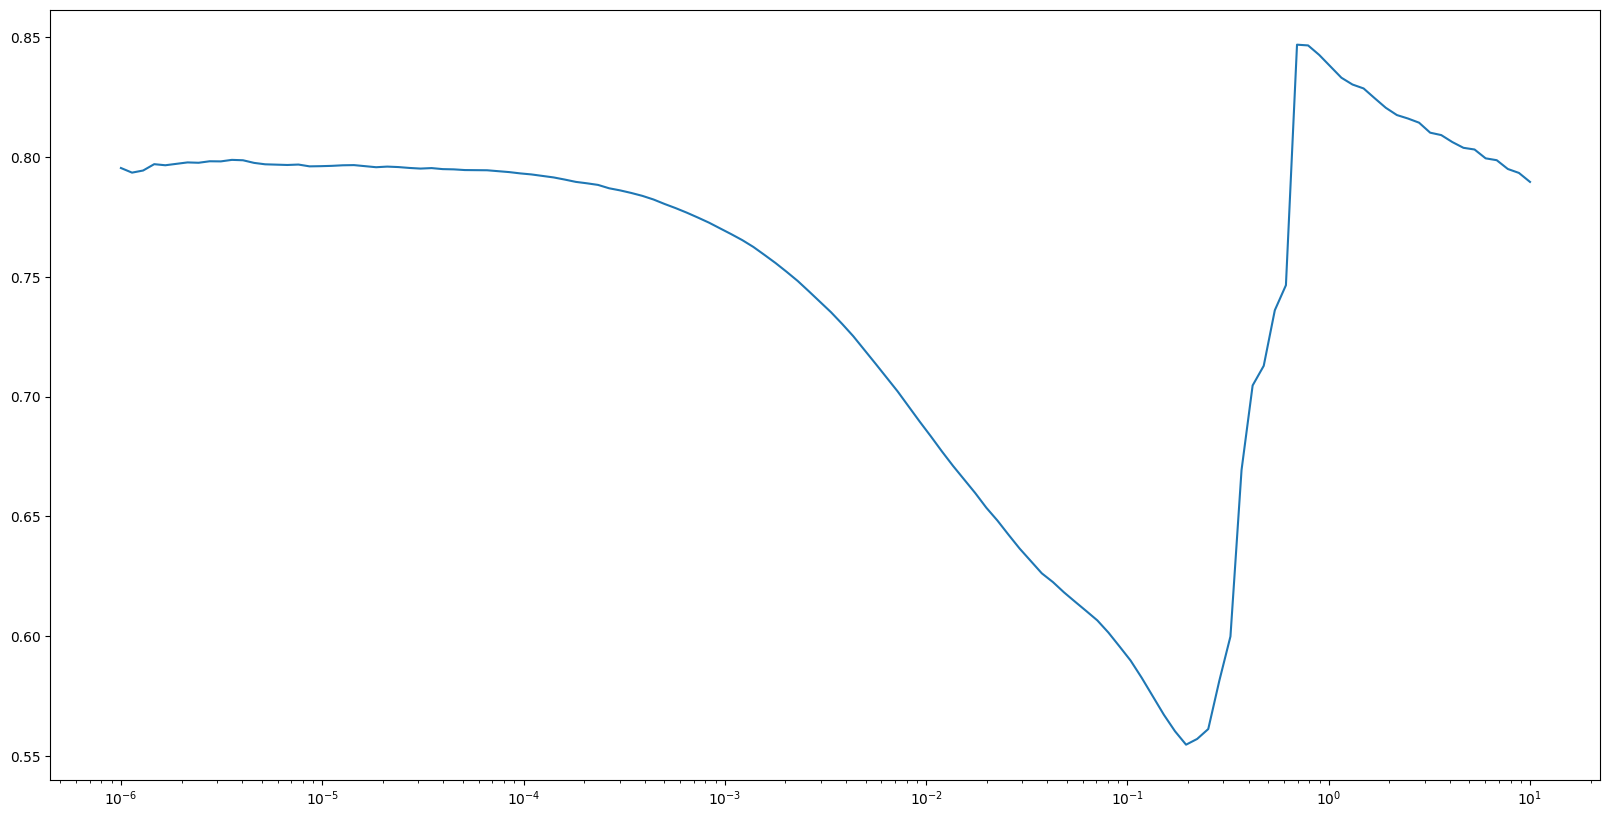

In [ ]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [ ]:
# define the model and train with scheduler
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 5
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [ ]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, mb: 25, train cost: 0.4927, val cost: 0.2798,train acc: 0.7340, val acc: 0.8793,dice: 0.6221445798873901, iou: 0.4515311121940613
epoch: 0, mb: 50, train cost: 0.3433, val cost: 0.1009,train acc: 0.8223, val acc: 0.9673,dice: 0.9226129651069641, iou: 0.856343150138855
epoch: 0, mb: 75, train cost: 0.2525, val cost: 0.0547,train acc: 0.8727, val acc: 0.9787,dice: 0.9491045475006104, iou: 0.9031387567520142
epoch: 0, mb: 100, train cost: 0.2016, val cost: 0.0482,train acc: 0.8997, val acc: 0.9809,dice: 0.955231249332428, iou: 0.9142991900444031
epoch: 0, mb: 125, train cost: 0.1695, val cost: 0.0354,train acc: 0.9165, val acc: 0.9856,dice: 0.9659504294395447, iou: 0.9341433048248291
epoch: 1, mb: 25, train cost: 0.0343, val cost: 0.0298,train acc: 0.9865, val acc: 0.9883,dice: 0.9720820784568787, iou: 0.9456806778907776
epoch: 1, mb: 50, train cost: 0.0322, val cost: 0.0267,train acc: 0.9873, val acc: 0.9896,dice: 0.9750602841377258, iou: 0.9513343572616577
epoch: 1, mb: 75, tr

## Plot some images

### Plotting Validation images

torch.Size([32, 224, 224])


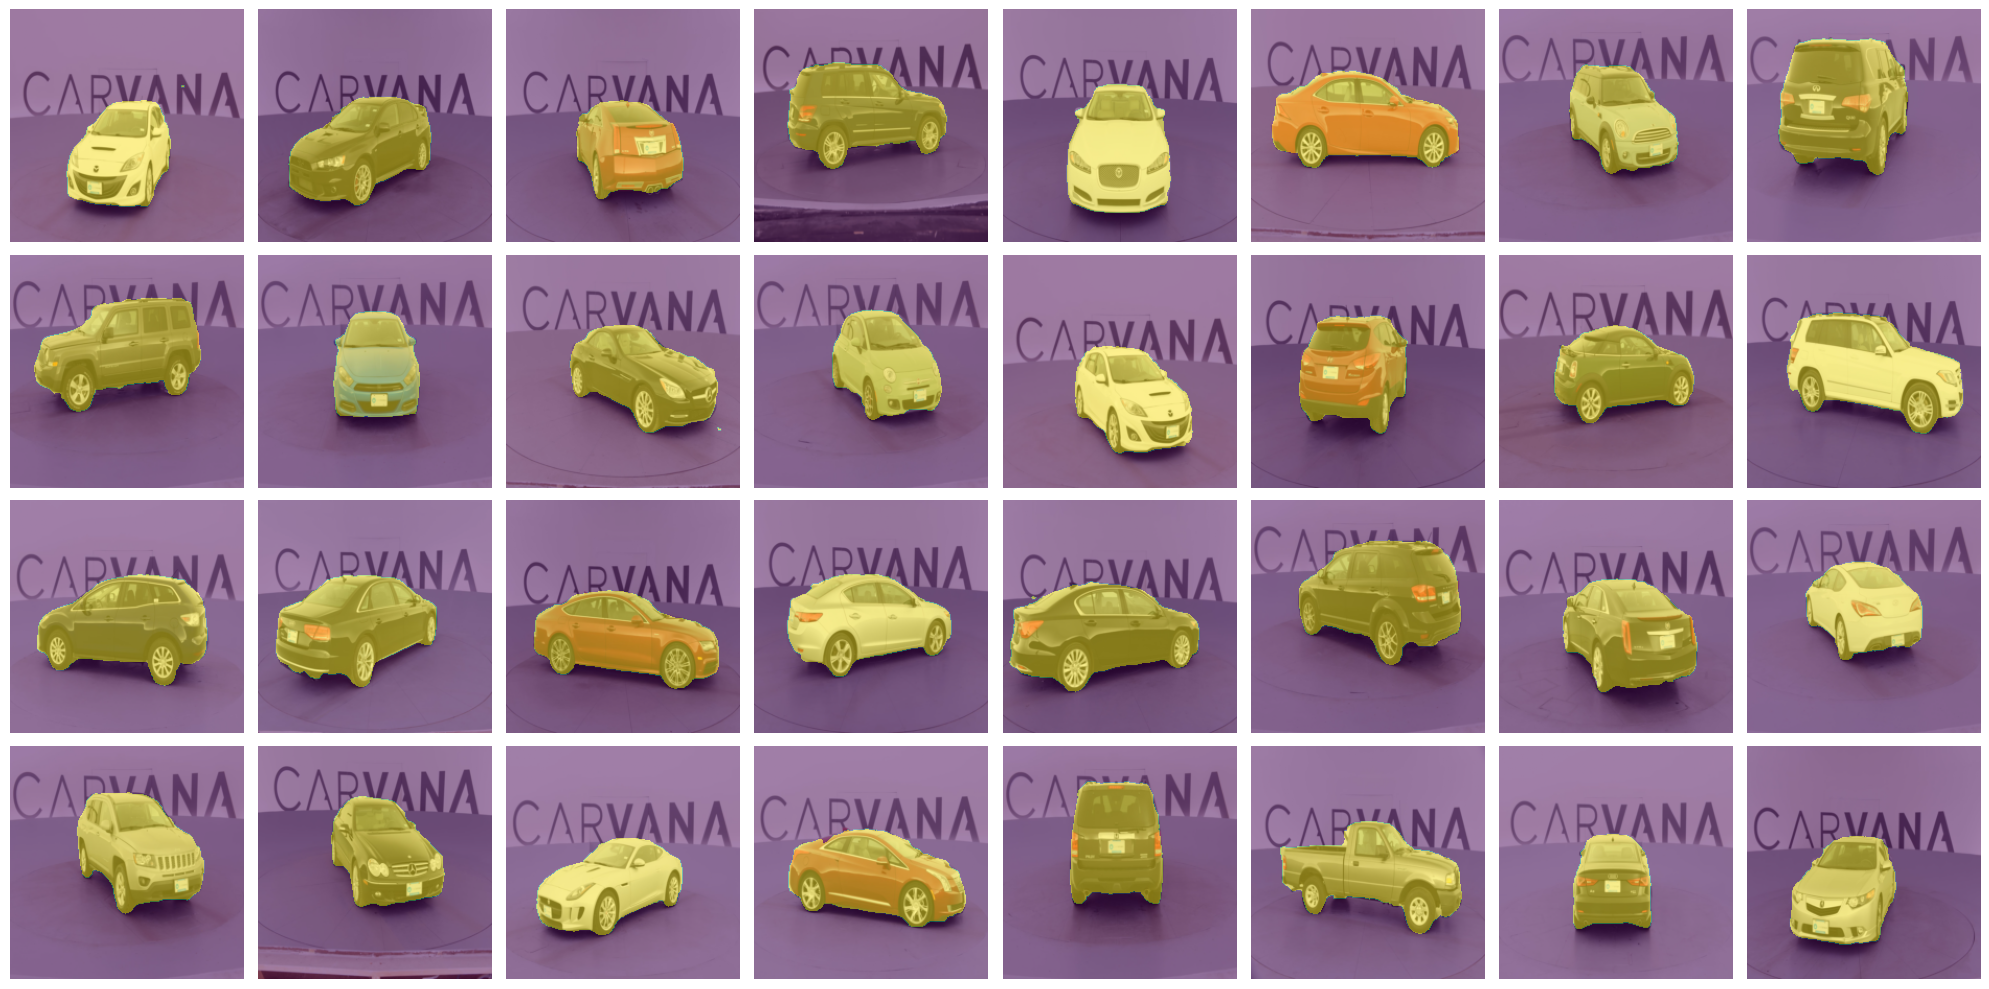

In [ ]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

### Plotting some Test Images

In [ ]:
test_set = Car_Dataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 224, 224])


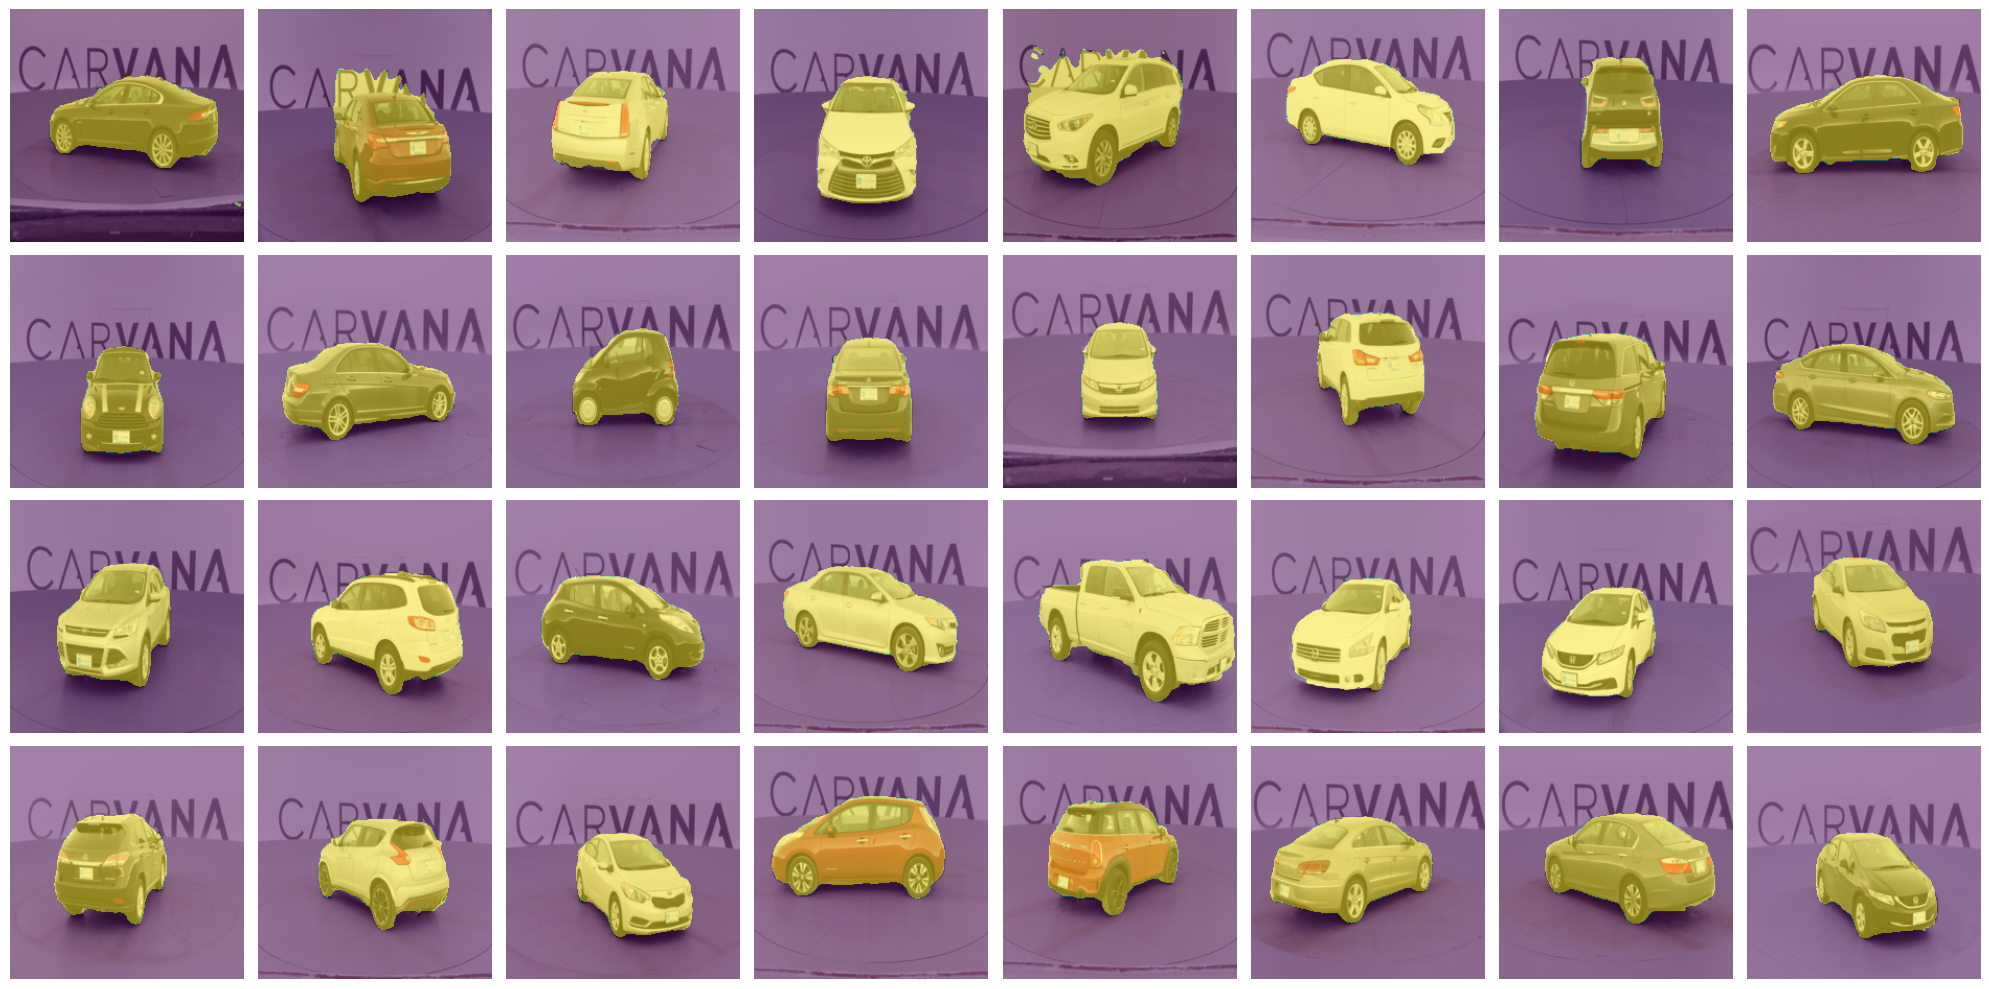

In [ ]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))